In [62]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif


%matplotlib inline
%config InlineBackend.figure_format='retina'

Let's import our dataset and have a quick look at it

In [15]:
df_main = pd.read_csv("dataset_1.csv")

In [16]:
df_main.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,target
0,1,5.1,3.5,1.4,0.2,Class_1
1,2,4.9,3.0,1.4,0.2,Class_1
2,3,4.7,3.2,1.3,0.2,Class_1
3,4,4.6,3.1,1.5,0.2,Class_1
4,5,5.0,3.6,1.4,0.2,Class_1


We first create a copy of our dataset, our analysis will be that copy only

In [17]:
df = df_main.copy()
df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,target
0,1,5.1,3.5,1.4,0.2,Class_1
1,2,4.9,3.0,1.4,0.2,Class_1
2,3,4.7,3.2,1.3,0.2,Class_1
3,4,4.6,3.1,1.5,0.2,Class_1
4,5,5.0,3.6,1.4,0.2,Class_1


Now let's use some tools to explore our data

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         150 non-null    int64  
 1   Feature_1  150 non-null    float64
 2   Feature_2  150 non-null    float64
 3   Feature_3  150 non-null    float64
 4   Feature_4  150 non-null    float64
 5   target     150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [19]:
df.shape

(150, 6)

From above we can conclude that their are no null values, so that saves some time

The first feature ie ID, is not required for further analysis, so let's just eliminate that.

In [20]:
df.drop(['Id'], axis=1, inplace = True)
df.head(2)

,Feature_1,Feature_2,Feature_3,Feature_4,target
0,5.1,3.5,1.4,0.2,Class_1
1,4.9,3.0,1.4,0.2,Class_1


Now we our describe data to better understand distribution

In [21]:
df.describe()

,Feature_1,Feature_2,Feature_3,Feature_4
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [22]:
## let's describe the "target" too
df.describe(include='object')

,target
count,150
unique,3
top,Class_1
freq,50


In [23]:
df['target'].value_counts()

Class_1    50
Class_2    50
Class_3    50
Name: target, dtype: int64

1. "target" variable is balanced (nothing much to do here)
2. "Feature" variables have fluctuating means, plot might give more insight

We will start by seperating "features" and "target" for easy of analysis and then let's plot features

In [39]:
df_features = df[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4']].copy()
df_target = df.filter(['target'], axis=1)

In [30]:
df_features.shape, df_target.shape

((150, 4), (150, 1))

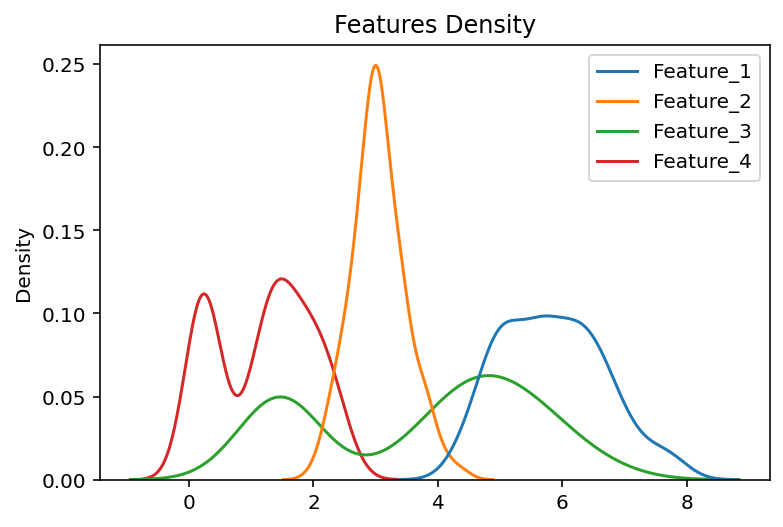

In [35]:
sns.kdeplot(data=df_features)
plt.title('Features Density')
plt.show()

Notice the data for feature_3 and features_4 like looks multimodal and varied a lot, let's normalize all to keep on same scale

In [40]:
## normalizing the data
min_max_scaler = MinMaxScaler()
df_features = pd.DataFrame(min_max_scaler.fit_transform(df_features), columns = df_features.columns)

In [42]:
df_features.head()

,Feature_1,Feature_2,Feature_3,Feature_4
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


In [46]:
df_features.describe() # we see now the data is between range 0 - 1

,Feature_1,Feature_2,Feature_3,Feature_4
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.439167,0.467571,0.457778
std,0.230018,0.180664,0.299054,0.317984
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


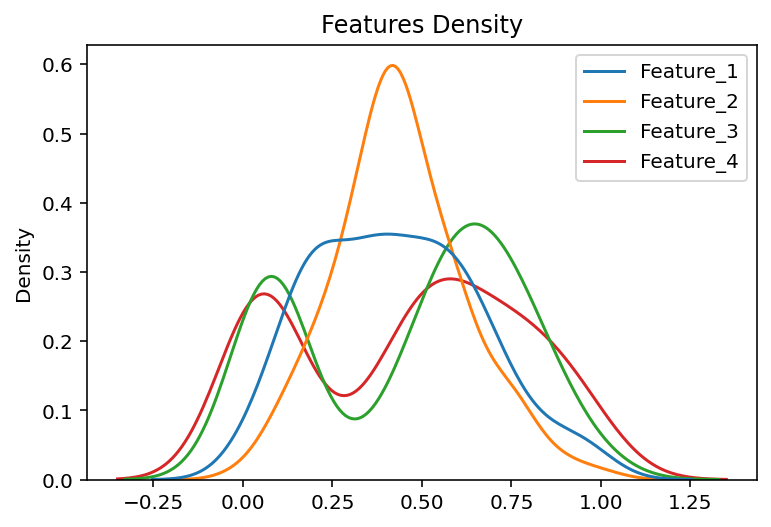

In [43]:
sns.kdeplot(data=df_features)
plt.title('Features Density')
plt.show()

In [49]:
df = pd.concat([df_features, df_target], axis = 1)
df.head(2)

,Feature_1,Feature_2,Feature_3,Feature_4,target
0,0.222222,0.625000,0.067797,0.041667,Class_1
1,0.166667,0.416667,0.067797,0.041667,Class_1


Now let's visualize the entire data with different target categories

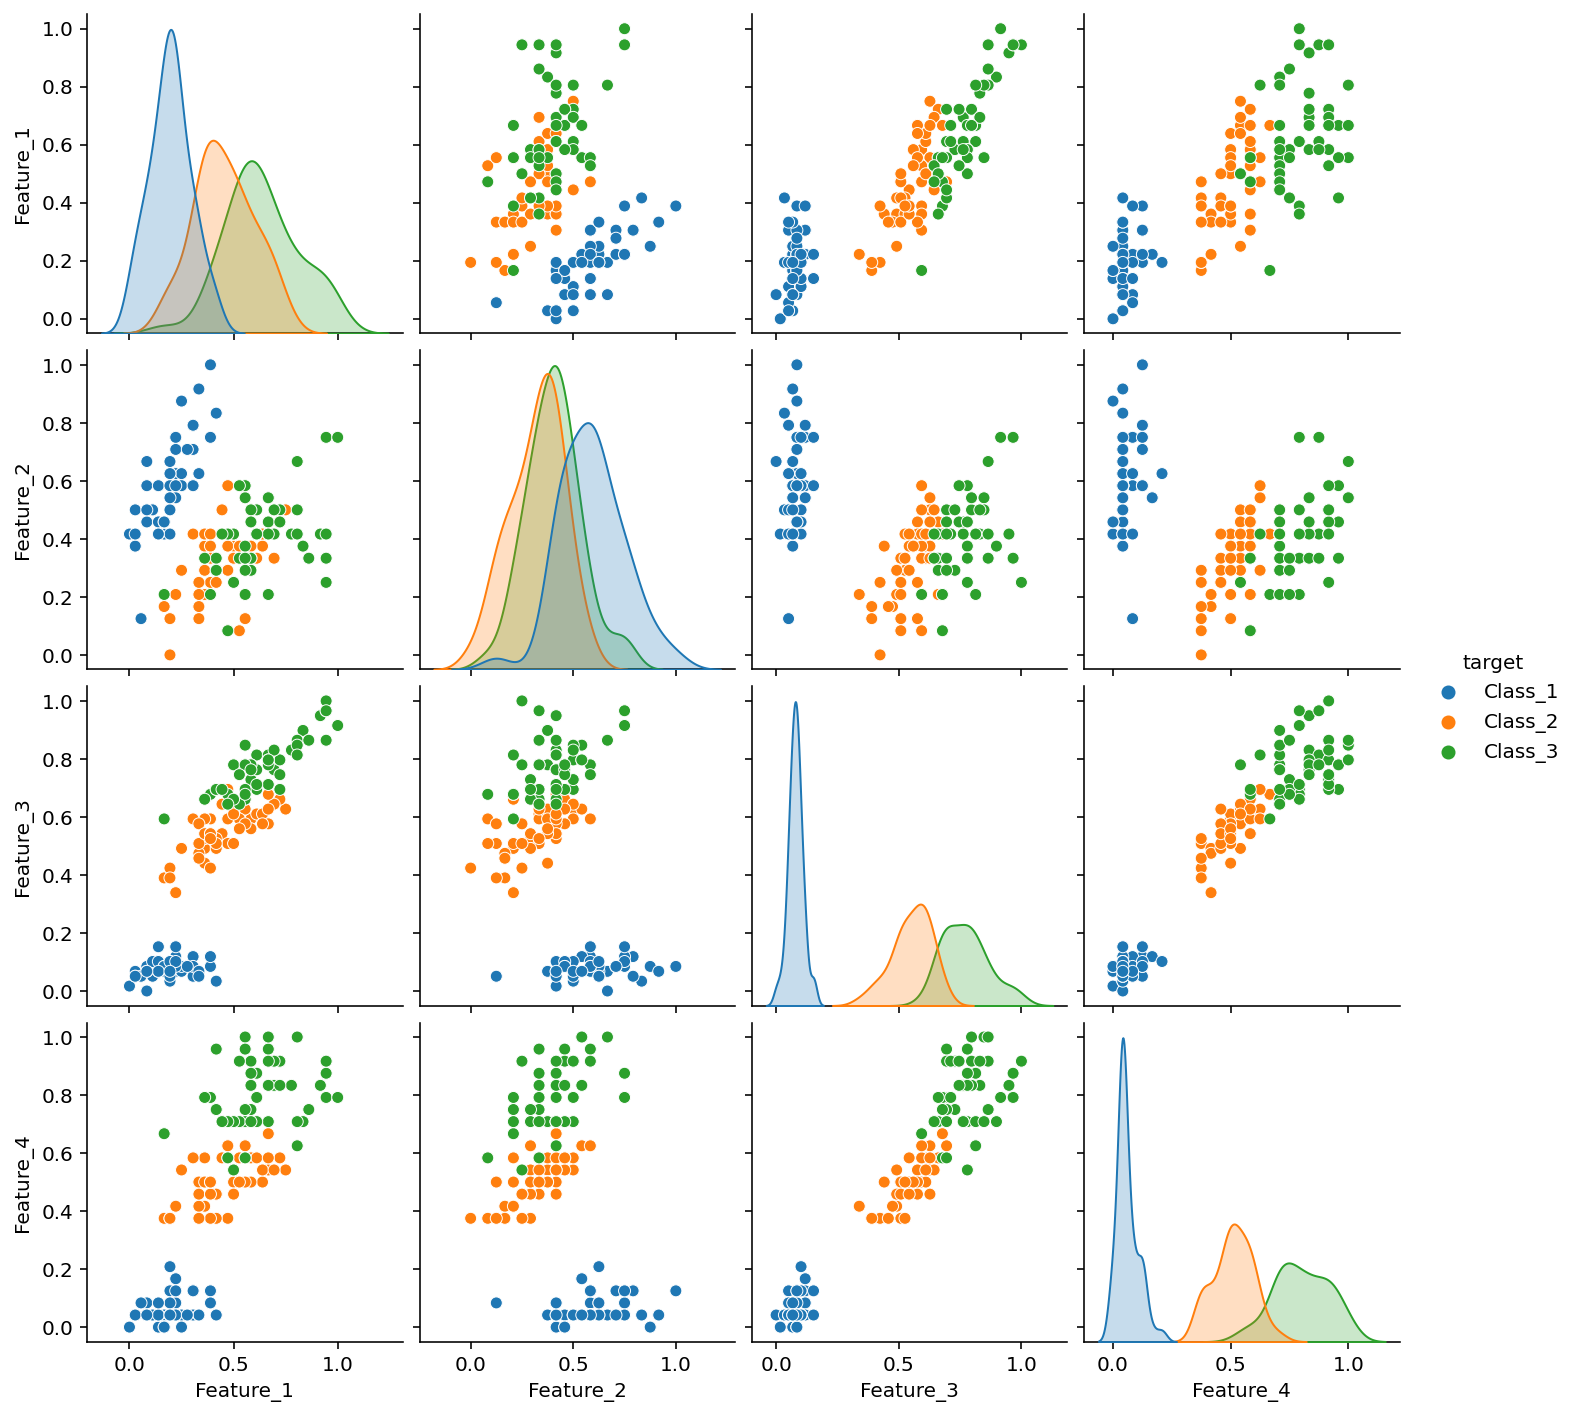

In [56]:
sns.pairplot(df, hue='target', vars=df_features.columns)
plt.show()

1. Before observing the plot, what we are looking for is feature that seperates target cleanly.
2. Clearly feature_3 and feature_4 are having quite segregated distribution for each target
3. The scatterplot for feature 3 and 4 also seems to point the same as above, so let's just select those two as our primary features.

So our hypothesis for now is that feature 3 and 4 might be the best features resulting in higher accuracy for classification

We use a metric Mutual Information, higher the score better the feature is related to classification task

In [75]:
# let's split data to make sure we do our hypothesis testing only on training samples
X_train, _, Y_train, _ = train_test_split(df_features, df['target'], test_size = 0.2, random_state = 21)

In [76]:
mutual_info = mutual_info_classif(X_train, Y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

Feature_3    1.030060
Feature_4    0.971763
Feature_1    0.553618
Feature_2    0.218755
dtype: float64

1. We can observe that feature_2 score is close to 0 (we can eliminate this).
2. We can also observe that feature_3 and feature_4 are best of features for this problem
3. feature_1 has 0.55 score, so we will consider it for now

In [63]:
## function to apply support vector machine
def apply_svc(features, target, report):
    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 21)
    model = svm.SVC()
    model.fit(X_train, Y_train.values.ravel())

    if report:
        generate_reports(model,X_train, X_test, Y_train, Y_test)
    
    return model

In [73]:
## function to apply support vector machine
def apply_randomforest(features, target, report):
    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 21)
    model = RandomForestClassifier()
    model.fit(X_train, Y_train.values.ravel())
    
    if report:
        generate_reports(model,X_train, X_test, Y_train, Y_test)
    
    return model

In [58]:
## function to generate report
def generate_reports(model,X_train, X_test, Y_train, Y_test):
    P_train = model.predict(X_train)
    P_test = model.predict(X_test)
    print(".................Report for Training set....................")
    print("Confusion Matrix")
    print(confusion_matrix(Y_train, P_train),"\n")
    print(Y_train.shape)
    print("Accuracy: ", accuracy_score(Y_train, P_train))
    
    
    print("Classification Report")
    print(classification_report(Y_train, P_train),"\n")
    
    
    print(".................Report for Testing set....................")
    print("Confusion Matrix")
    print(confusion_matrix(Y_test, P_test), "\n")
    print("Accuracy: ", accuracy_score(Y_test, P_test))

    
    print("Classification Report")
    print(classification_report(Y_test, P_test),"\n")

In [77]:
## Before fitting the models, let's make sure to drop feature 2
df_features.drop(['Feature_2'], axis = 1, inplace= True)
df_features.head(1)

,Feature_1,Feature_3,Feature_4
0,0.222222,0.067797,0.041667


In [78]:
model_1_v1 = apply_svc(df_features, df_target, True)

.................Report for Training set....................
Confusion Matrix
[[39  0  0]
 [ 0 37  1]
 [ 0  2 41]] 

(120, 1)
Accuracy:  0.975
Classification Report
              precision    recall  f1-score   support

     Class_1       1.00      1.00      1.00        39
     Class_2       0.95      0.97      0.96        38
     Class_3       0.98      0.95      0.96        43

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.98       120
weighted avg       0.98      0.97      0.98       120
 

.................Report for Testing set....................
Confusion Matrix
[[11  0  0]
 [ 0 10  2]
 [ 0  0  7]] 

Accuracy:  0.9333333333333333
Classification Report
              precision    recall  f1-score   support

     Class_1       1.00      1.00      1.00        11
     Class_2       1.00      0.83      0.91        12
     Class_3       0.78      1.00      0.88         7

    accuracy                           0.93        30
   macro avg

In [79]:
model_2_v1 = apply_randomforest(df_features, df_target, True)

.................Report for Training set....................
Confusion Matrix
[[39  0  0]
 [ 0 38  0]
 [ 0  0 43]] 

(120, 1)
Accuracy:  1.0
Classification Report
              precision    recall  f1-score   support

     Class_1       1.00      1.00      1.00        39
     Class_2       1.00      1.00      1.00        38
     Class_3       1.00      1.00      1.00        43

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120
 

.................Report for Testing set....................
Confusion Matrix
[[11  0  0]
 [ 0 10  2]
 [ 0  1  6]] 

Accuracy:  0.9
Classification Report
              precision    recall  f1-score   support

     Class_1       1.00      1.00      1.00        11
     Class_2       0.91      0.83      0.87        12
     Class_3       0.75      0.86      0.80         7

    accuracy                           0.90        30
   macro avg       0.89      

The results above do perform decent on the problem, but perhaps we can tune it little bit more by removing feature_1

In [81]:
model_1_v2 = apply_svc(df_features.drop(['Feature_1'], axis=1), df_target, True)

.................Report for Training set....................
Confusion Matrix
[[39  0  0]
 [ 0 37  1]
 [ 0  3 40]] 

(120, 1)
Accuracy:  0.9666666666666667
Classification Report
              precision    recall  f1-score   support

     Class_1       1.00      1.00      1.00        39
     Class_2       0.93      0.97      0.95        38
     Class_3       0.98      0.93      0.95        43

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120
 

.................Report for Testing set....................
Confusion Matrix
[[11  0  0]
 [ 0 11  1]
 [ 0  0  7]] 

Accuracy:  0.9666666666666667
Classification Report
              precision    recall  f1-score   support

     Class_1       1.00      1.00      1.00        11
     Class_2       1.00      0.92      0.96        12
     Class_3       0.88      1.00      0.93         7

    accuracy                           0.97        30

In [82]:
model_2_v2 = apply_randomforest(df_features.drop(['Feature_1'], axis=1), df_target, True)

.................Report for Training set....................
Confusion Matrix
[[39  0  0]
 [ 0 37  1]
 [ 0  0 43]] 

(120, 1)
Accuracy:  0.9916666666666667
Classification Report
              precision    recall  f1-score   support

     Class_1       1.00      1.00      1.00        39
     Class_2       1.00      0.97      0.99        38
     Class_3       0.98      1.00      0.99        43

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120
 

.................Report for Testing set....................
Confusion Matrix
[[11  0  0]
 [ 0 10  2]
 [ 0  0  7]] 

Accuracy:  0.9333333333333333
Classification Report
              precision    recall  f1-score   support

     Class_1       1.00      1.00      1.00        11
     Class_2       1.00      0.83      0.91        12
     Class_3       0.78      1.00      0.88         7

    accuracy                           0.93        30

**Let's summarize all the results**

1. We 2 version's of our model, for both SVM and Random Forest.

2. Version 1 takes 3 features(1,3,4) into consideration.

3. Version 2 takes 2 features(3,4) into consideration.

4. Our first versions do perform well on test set,
    but the models error difference is 
    4% for SVM and 
    10% for Random Forest.
    
5. Whereas if we consider second version, it has error difference of 
    0% for SVM and 6% for Random Forest.
    
6. If we had to choose a model, the least overfitting model with high accuracy would be ideal choice,
    so SVM is the way to go with our 3 features(3,4) and accuracy 96% on both the sets.
    
7. If we observe just our 2nd SVM model, it shows that Class_2 and Class_3 are the ones we have more trouble to recall and precisely classify.